In [ ]:
%mkdir data
%cd ./data/



/content/data


In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2021-10-26 11:08:44--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2021-10-26 11:08:44--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  28.8MB/s    in 27s     

2021-10-26 11:09:11 (28.1 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2021-10-26 11:09:12--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Co

In [ ]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

In [ ]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz


In [ ]:
import os
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

input_dir = "/content/data/images/"
target_dir = "/content/data/annotations/trimaps/"
img_size = (224, 224)
num_classes = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Number of samples: 7390
Found GPU at: /device:GPU:0


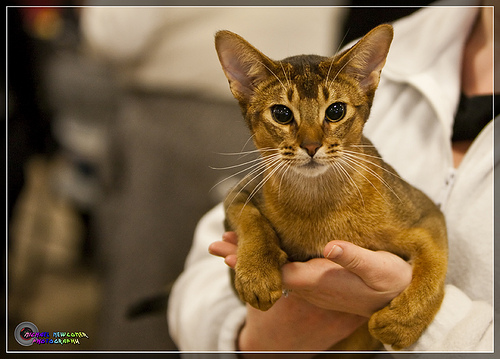

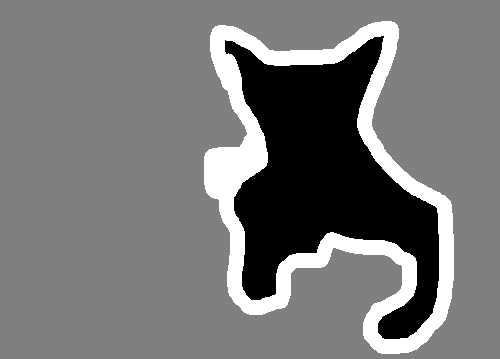

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[29]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[29]))
display(img)

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    #skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_3, 64*8)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip3, 64*4)
    decoder_2 = decoder(decoder_1, skip2, 64*2)
    decoder_3 = decoder(decoder_2, skip1, 64)
    #decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(num_classes, 1, padding="same", activation="sigmoid")(decoder_3)

    model = Model(input1, out)
    return model

In [ ]:
input_shape = (224, 224, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
798/798 [==============================] - 655s 772ms/step - loss: 0.6796 - val_loss: 0.8478
Epoch 2/15
798/798 [==============================] - 616s 772ms/step - loss: 0.5013 - val_loss: 0.4617
Epoch 3/15
798/798 [==============================] - 616s 772ms/step - loss: 0.4302 - val_loss: 0.4306
Epoch 4/15
798/798 [==============================] - 615s 771ms/step - loss: 0.3912 - val_loss: 0.4134
Epoch 5/15
798/798 [==============================] - 613s 768ms/step - loss: 0.3650 - val_loss: 0.3888
Epoch 6/15
798/798 [==============================] - 613s 769ms/step - loss: 0.3446 - val_loss: 0.3668
Epoch 7/15
798/798 [==============================] - 613s 769ms/step - loss: 0.3267 - val_loss: 0.3564
Epoch 8/15
798/798 [==============================] - 614s 769ms/step - loss: 0.3124 - val_loss: 0.3988
Epoch 9/15
798/798 [==============================] - 614s 769ms/step - loss: 0.2984 - val_loss: 0.3295
Epoch 10/15
798/798 [==============================] - 613s 769m

In [ ]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


  def display_mask(i):
      """Quick utility to display a model's prediction."""
      mask = np.argmax(val_preds[i], axis=-1)
      mask = np.expand_dims(mask, axis=-1)
      img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
      display(img)

for i in range(18):
  # Display input image
  display(Image(filename=val_input_img_paths[i]))

  # Display ground-truth target mask
  img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))  
  display(img)

  # Display mask predicted by our model
  display_mask(i)  # Note that the model only sees inputs at 150x150.

In [ ]:
from PIL import Image
image = Image.open('/content/data/images/Abyssinian_114.jpg')


pixels = list(image.getdata().resize((224,224)))
pixels = np.array(pixels,dtype=float)
print(pixels.shape)
np.savetxt('input2.csv',pixels,delimiter=',',fmt='%1.4f')

(50176, 3)
